In [153]:
import fastf1
import fastf1.plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np

from fastf1.ergast import Ergast

fastf1.plotting.setup_mpl(misc_mpl_mods=False)
ergast = Ergast()

YEAR = 2023
NAME = f'{YEAR}_Formula15_OverTime.csv'

In [154]:
races = ergast.get_race_schedule(YEAR)
results = []

for round, race in races['raceName'].items():
    temp = ergast.get_race_results(season=YEAR, round=round + 1)
    
    if(temp.content):
        temp = temp.content[0]
        # print(temp)
        
        # If there is a sprint, get the results as well
        sprint = ergast.get_sprint_results(season=2022, round=round + 1)
        if sprint.content and sprint.description['round'][0] == round + 1:
            temp = pd.merge(temp, sprint.content[0], on='driverCode', how='left')
            # Add sprint points and race points to get the total
            temp['points'] = temp['points_x'] + temp['points_y']
            temp.drop(columns=['points_x', 'points_y'], inplace=True)

        # Add round no. and grand prix name
        temp['round'] = round + 1
        temp['race'] = race.removesuffix(' Grand Prix')
        temp = temp.reindex(columns=['round', 'race', 'driverCode', 'constructorName','points'])
        results.append(temp)
    else:
        break

# Append all races into a single dataframe
results = pd.concat(results)
races = results['race'].drop_duplicates()

# Get all drivers
drivers = results.driverCode.unique()

In [155]:
# Write to file for inspection later    
results.to_csv(NAME)

In [156]:
# Remove 1st place (Verstappen)
no_max = results['driverCode'] == 'VER'
results = results[~no_max]
results.reset_index()

drivers_to_remove = np.where(drivers == 'VER')
drivers = np.delete(drivers, drivers_to_remove)

# Last round
last_round = results['round'].max()

# Adds a total points column
results['TotalPoints'] = results.groupby('driverCode')['points'].cumsum()
results.reset_index()

# Creates a new dataframe specifically for the recent results
last_five_races = pd.DataFrame(columns=['driverCode','RecentPoints'])

# Adds a last 5 races frame
for driver in drivers:
    driver_recent_points = results.loc[results['driverCode'] == driver].sort_values('round', ascending=False)[:5]['points'].sum()
    last_five_races.loc[len(last_five_races)] = [driver, driver_recent_points]

last_five_races.sort_values('RecentPoints', ascending=False, inplace=True)
last_five_races['color'] = last_five_races['driverCode'].apply(fastf1.plotting.driver_color)
last_five_races
# Get the top 10 in the WDC

,driverCode,RecentPoints,color
3,HAM,65.0,#00d2be
1,ALO,58.0,#006f62
0,PER,44.0,#716de2
5,RUS,41.0,#24ffff
17,LEC,40.0,#dc0000
2,SAI,33.0,#ff8181
15,NOR,32.0,#eeb370
16,OCO,23.0,#70c2ff
18,PIA,13.0,#ff8700
4,STR,12.0,#25a617


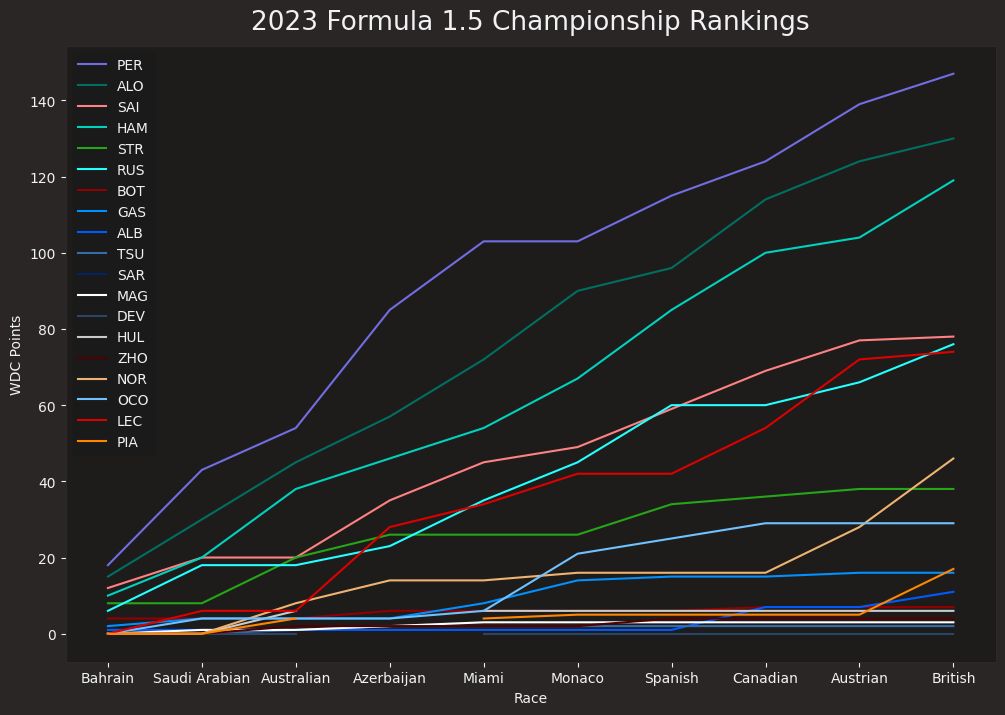

In [157]:
fig, ax = plt.subplots(figsize=(12,8))


for driver in drivers:
    driver_points = results.loc[results['driverCode'] == driver]
    color = fastf1.plotting.driver_color(driver)
    ax.plot(driver_points['race'], driver_points['TotalPoints'], color=color, label=driver)

ax.set_title(f'{YEAR} Formula 1.5 Championship Rankings')
ax.set_xlabel('Race')
ax.set_ylabel('WDC Points')
ax.legend()
plt.savefig(f'graphs/{YEAR}/{YEAR} Formula 15 Championship Rankings.png', format='png')

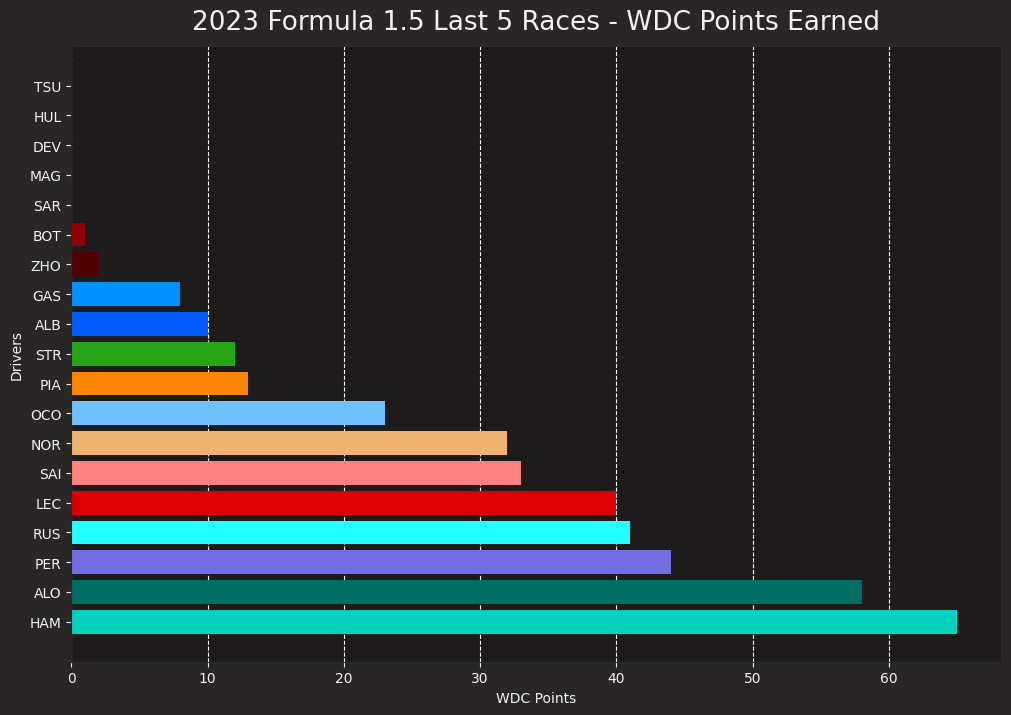

In [158]:
fig, ax = plt.subplots(figsize=(12,8))

ax.barh(
    y=last_five_races['driverCode'],
    width=last_five_races['RecentPoints'],
    color=last_five_races['color']
    )

ax.set_axisbelow(True)
ax.xaxis.grid(True, which='major', linestyle='--', color='white', zorder=-1000)
ax.set_xlabel('WDC Points')
ax.set_ylabel('Drivers')
ax.set_title(f'{YEAR} Formula 1.5 Last 5 Races - WDC Points Earned')
plt.savefig(f'graphs/{YEAR}/{YEAR} Formula 15 Championship - Last 5 Races.png', format='png')